In [21]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz 
import graphviz

from sklearn.metrics import confusion_matrix
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [30]:
#data=pd.read_csv('data/bdata.csv') #for 54 files
data=pd.read_csv('data/sdata.csv')
data=data.drop(['Unnamed: 0'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15950 entries, 0 to 15949
Data columns (total 52 columns):
Unnamed: 0.1                15950 non-null int64
creator_name                15950 non-null object
name                        15950 non-null object
creator_id                  15950 non-null int64
backers_count               15950 non-null int64
blurb                       15950 non-null object
is_starred                  15950 non-null bool
category.id                 15950 non-null int64
category.name               15950 non-null object
category.parent_id          15950 non-null float64
category.slug               15950 non-null object
country                     15950 non-null object
currency                    15950 non-null object
goal                        15950 non-null float64
staff_pick                  15950 non-null bool
state                       15950 non-null object
usd_pledged                 15950 non-null float64
usd_type                    15950 non-null obj

# word cloud

In [23]:

def show_wordcloud(data, title = None):
    '''Split names by space and generate word counts.'''
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

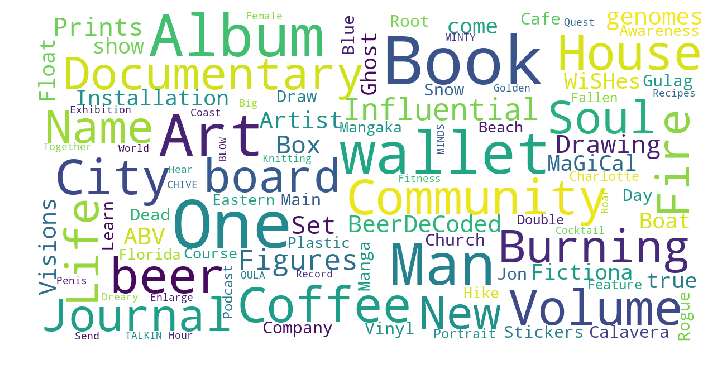

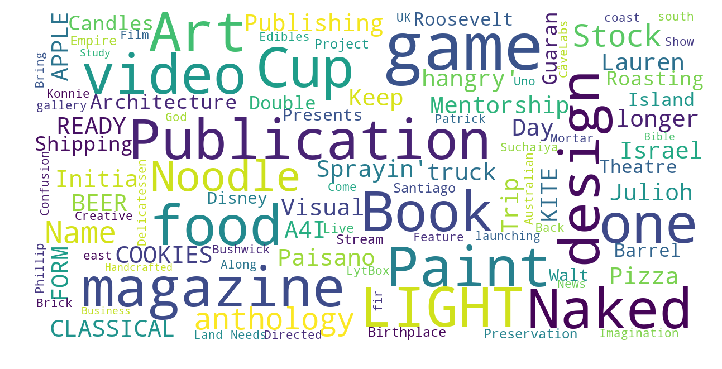

In [24]:
show_wordcloud(data[data.state == 'successful']['name'])
show_wordcloud(data[data.state == 'failed']['name'])

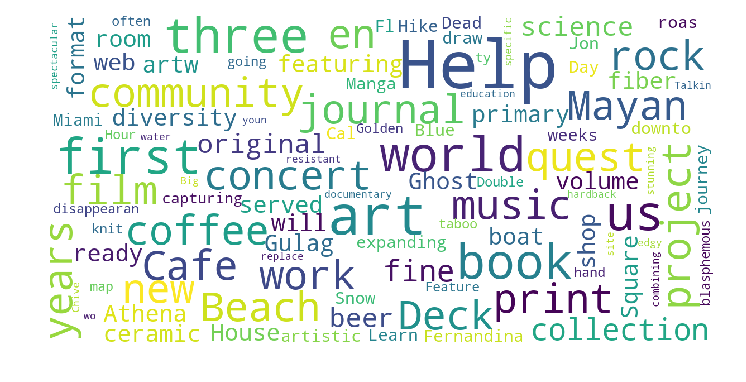

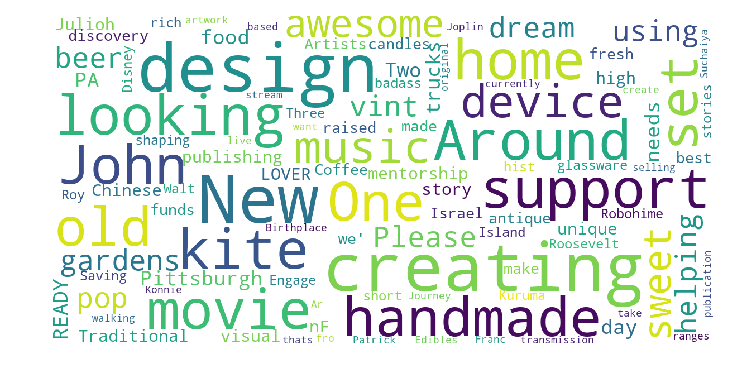

In [163]:
show_wordcloud(data[data.state == 'successful']['blurb'])
show_wordcloud(data[data.state == 'failed']['blurb'])

In [25]:
corr_df=data.corr()
cor_st=corr_df.loc['state_num']
print(cor_st.nsmallest())
print(cor_st.nlargest())

category.id          -0.335087
deadline_yr          -0.201259
created_at_yr        -0.199914
launched_at_yr       -0.198035
category.slug_food   -0.165347
Name: state_num, dtype: float64
state_num              1.000000
success                1.000000
staff_pick             0.272324
name_non_character     0.148786
name_number_of_word    0.144489
Name: state_num, dtype: float64


## Data visualization

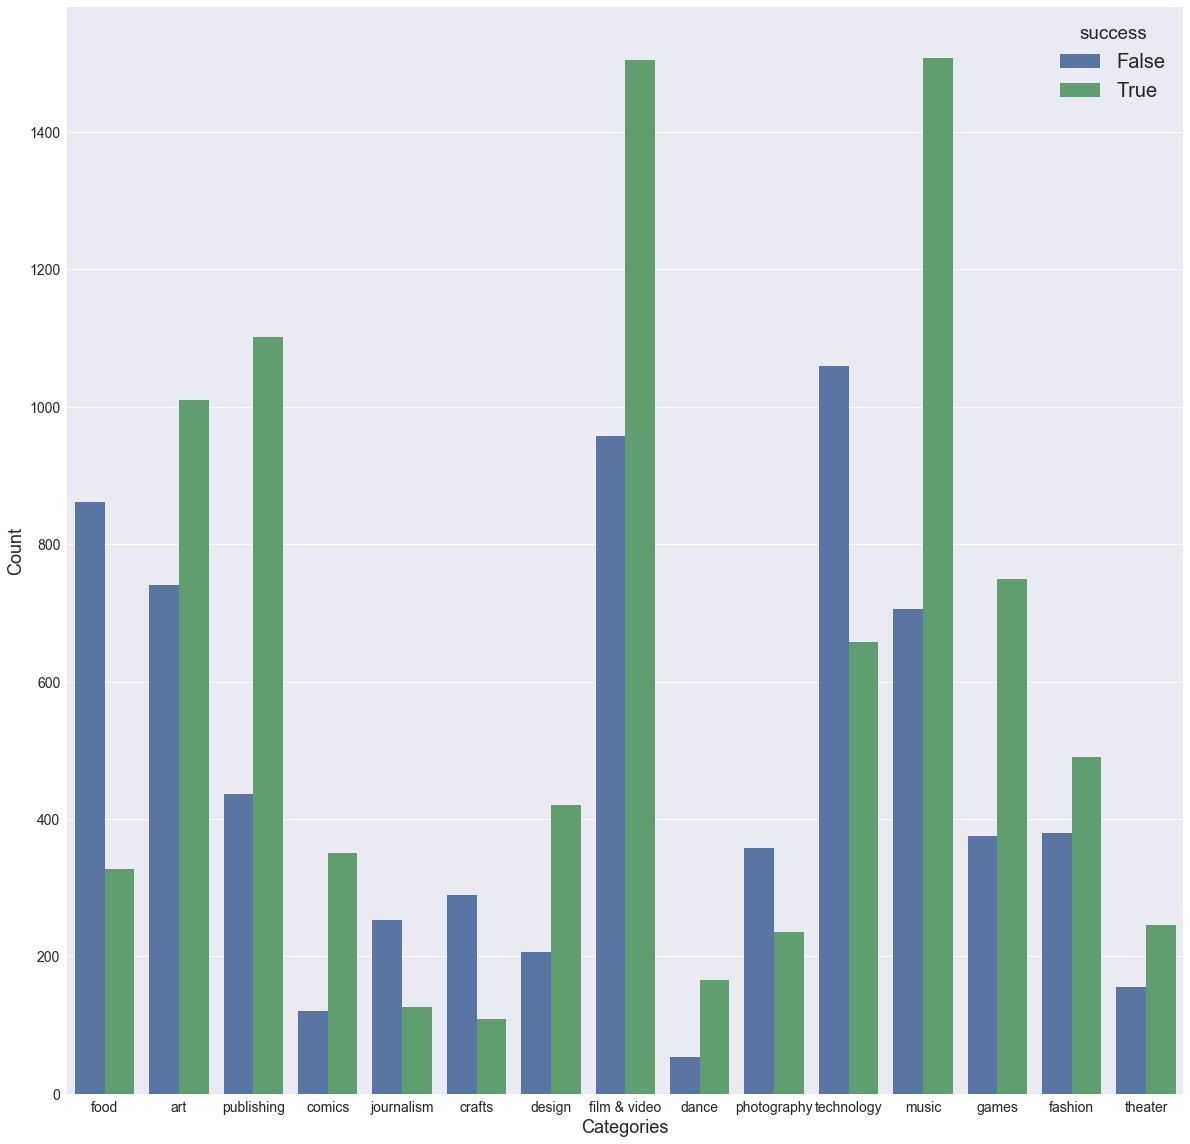

In [31]:
from seaborn import set
plt.rcParams['figure.figsize']=(20,20)
set(font_scale=2)
b=sns.countplot(x='category.slug', hue='success',data=data)
b.set_xlabel("Categories",fontsize=18)
b.set_ylabel("Count",fontsize=18)
b.tick_params(labelsize=14)

Text(0,0.5,'Count')

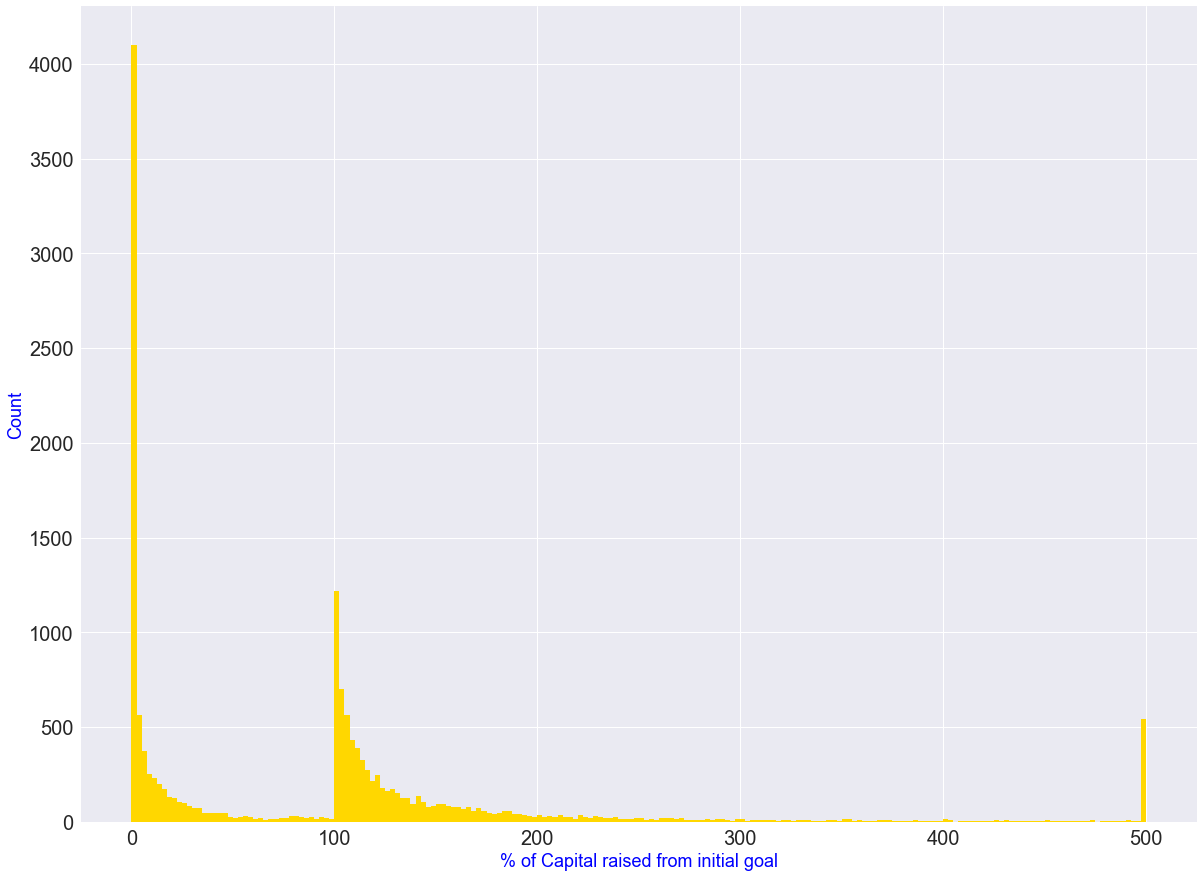

In [32]:
PP=np.clip(data['pledge_perc'], 0, 500)
fig=PP.hist(bins = 200, figsize = (20,15),color='gold')
fig.set_xlabel("% of Capital raised from initial goal",fontsize=18,color='b')
fig.set_ylabel("Count",fontsize=18,color='b')



In [33]:
corr_matrix = data.corr()
corr_matrix["success"].sort_values()

category.id                -0.335087
deadline_yr                -0.201259
created_at_yr              -0.199914
launched_at_yr             -0.198035
deadline-launched          -0.083001
goal_1000                  -0.082135
goal_500                   -0.082034
goal_10                    -0.081988
goal                       -0.081988
deadline_hr                -0.062170
category.parent_id         -0.052169
created_at_mo              -0.026364
deadline_day_in_month      -0.015655
launched_at_day_in_month   -0.015207
launched_at_mo             -0.014790
name_is_upper              -0.013175
name_is_question           -0.012906
deadline_day_in_week       -0.011504
deadline_mo                -0.009745
launched_at_hr             -0.009481
launched_at_day_in_week    -0.005620
created_at_day_in_week     -0.005002
created_at_day_in_month    -0.004577
name_vowel_ratio           -0.004272
Unnamed: 0.1               -0.000519
creator_id                  0.000831
blurb_vowel_ratio           0.005940
b

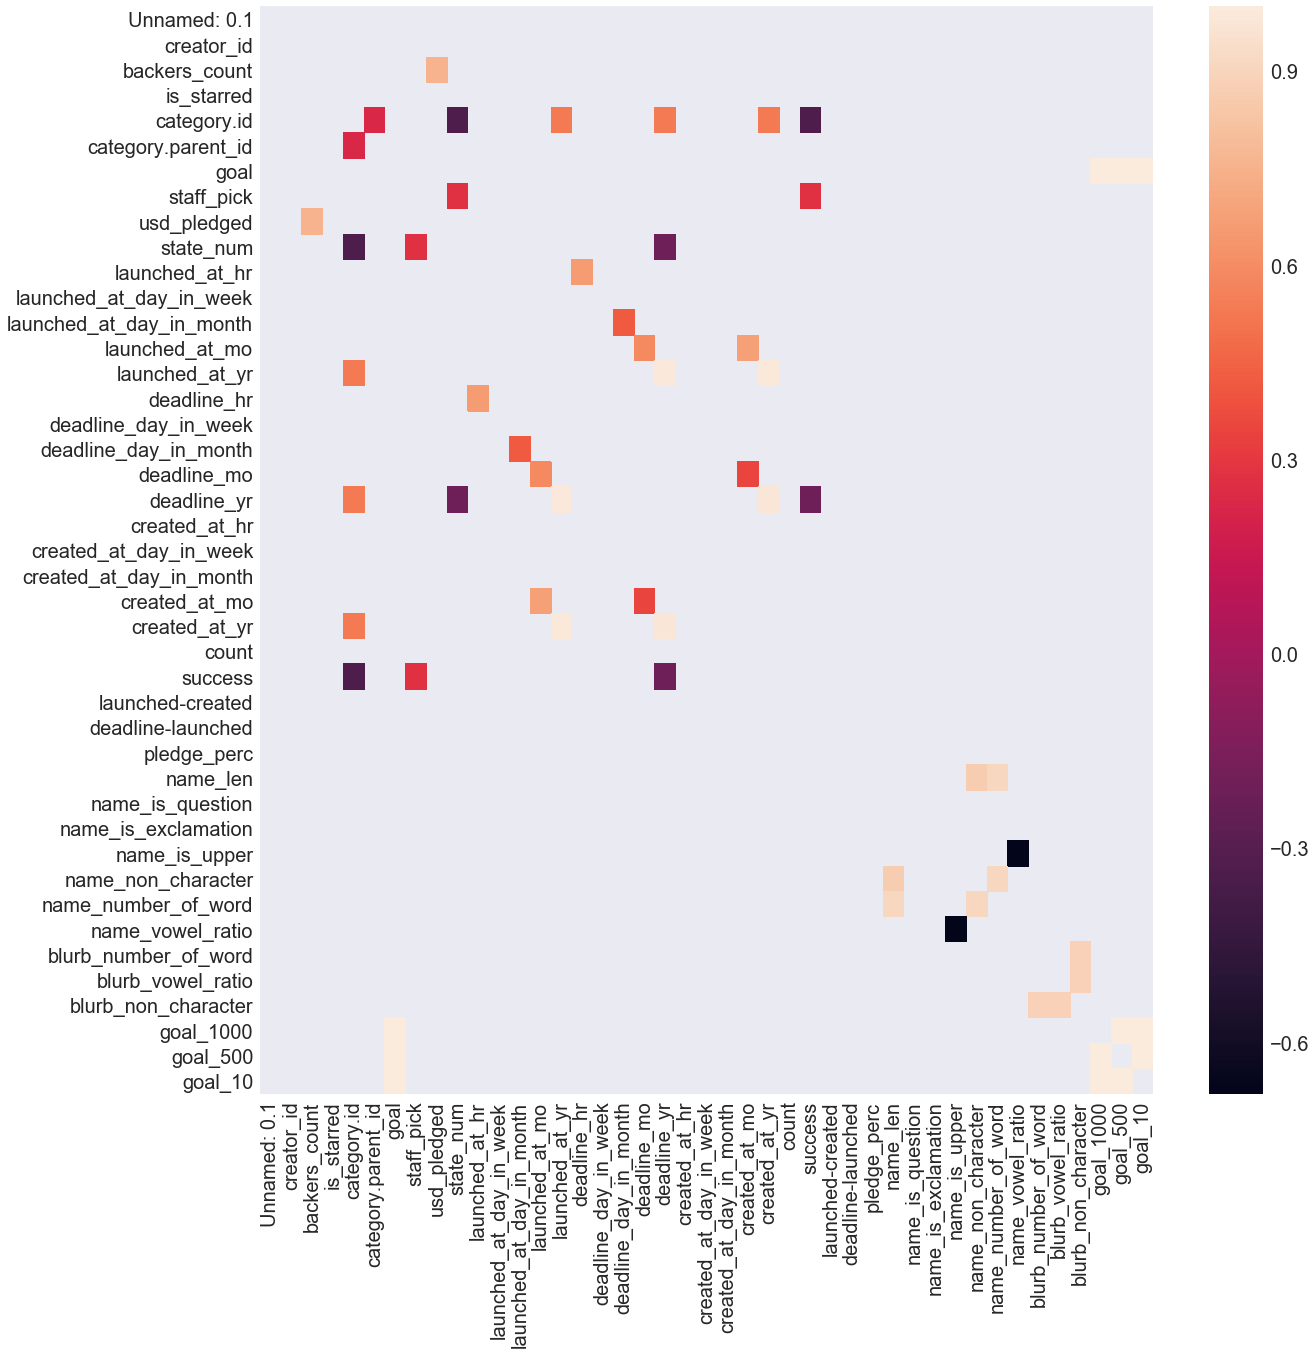

In [34]:
sns.heatmap(corr_matrix[(corr_matrix<1) & ((corr_matrix >= 0.2) | (corr_matrix <= -0.2)) ] )

Text(0,0.5,'USD Pledged')

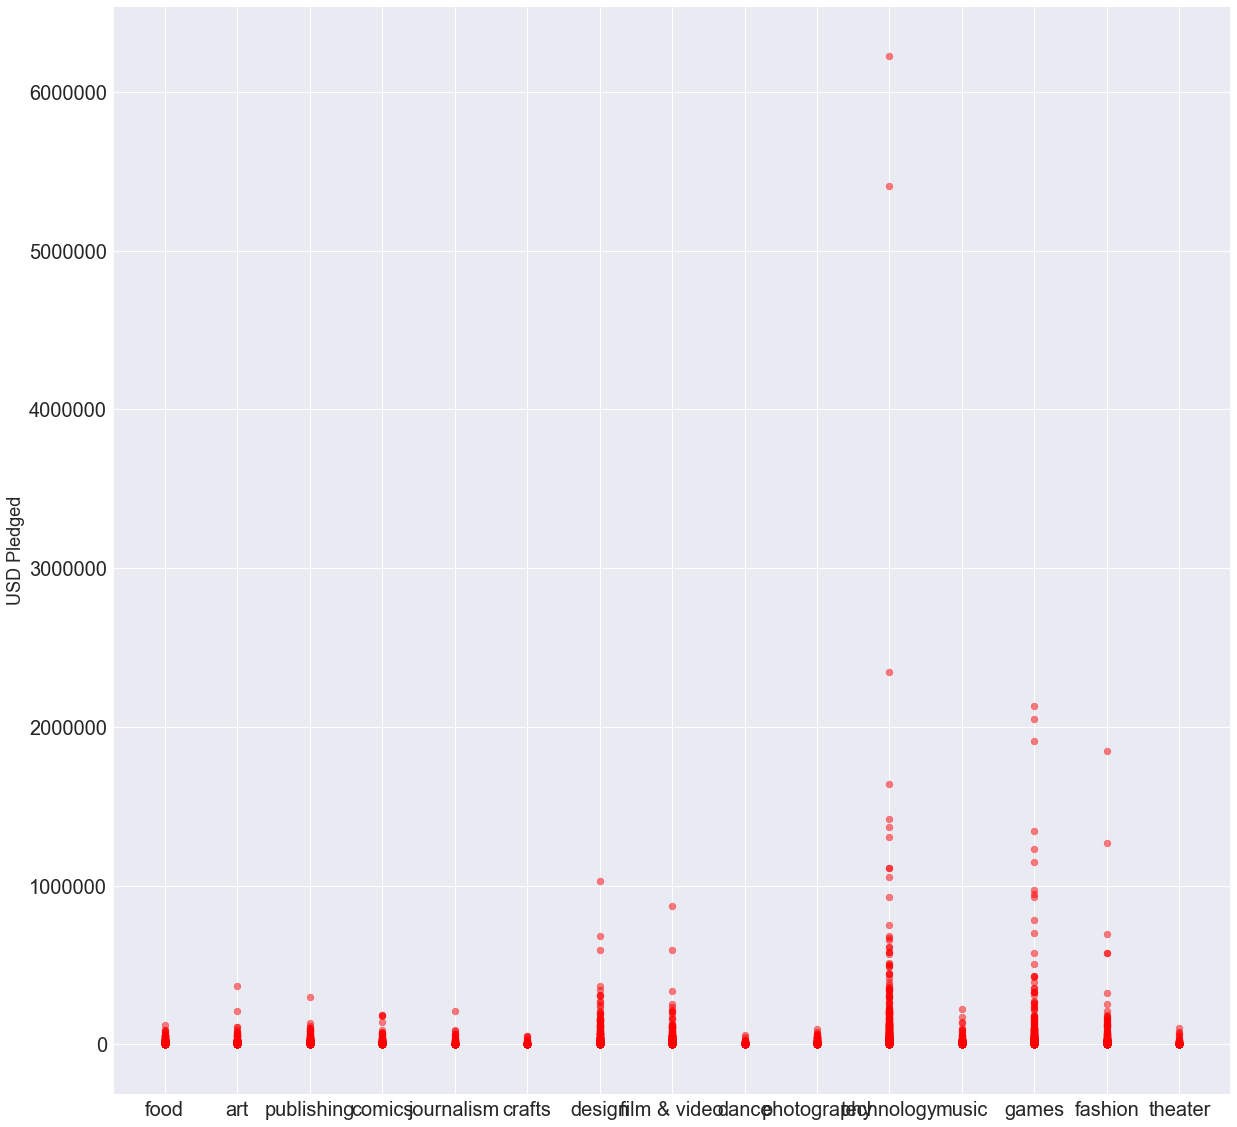

In [35]:
plt.scatter(x='category.slug', y='usd_pledged', data=data, alpha=0.5, color='r')
plt.ylabel("USD Pledged",fontsize=18)

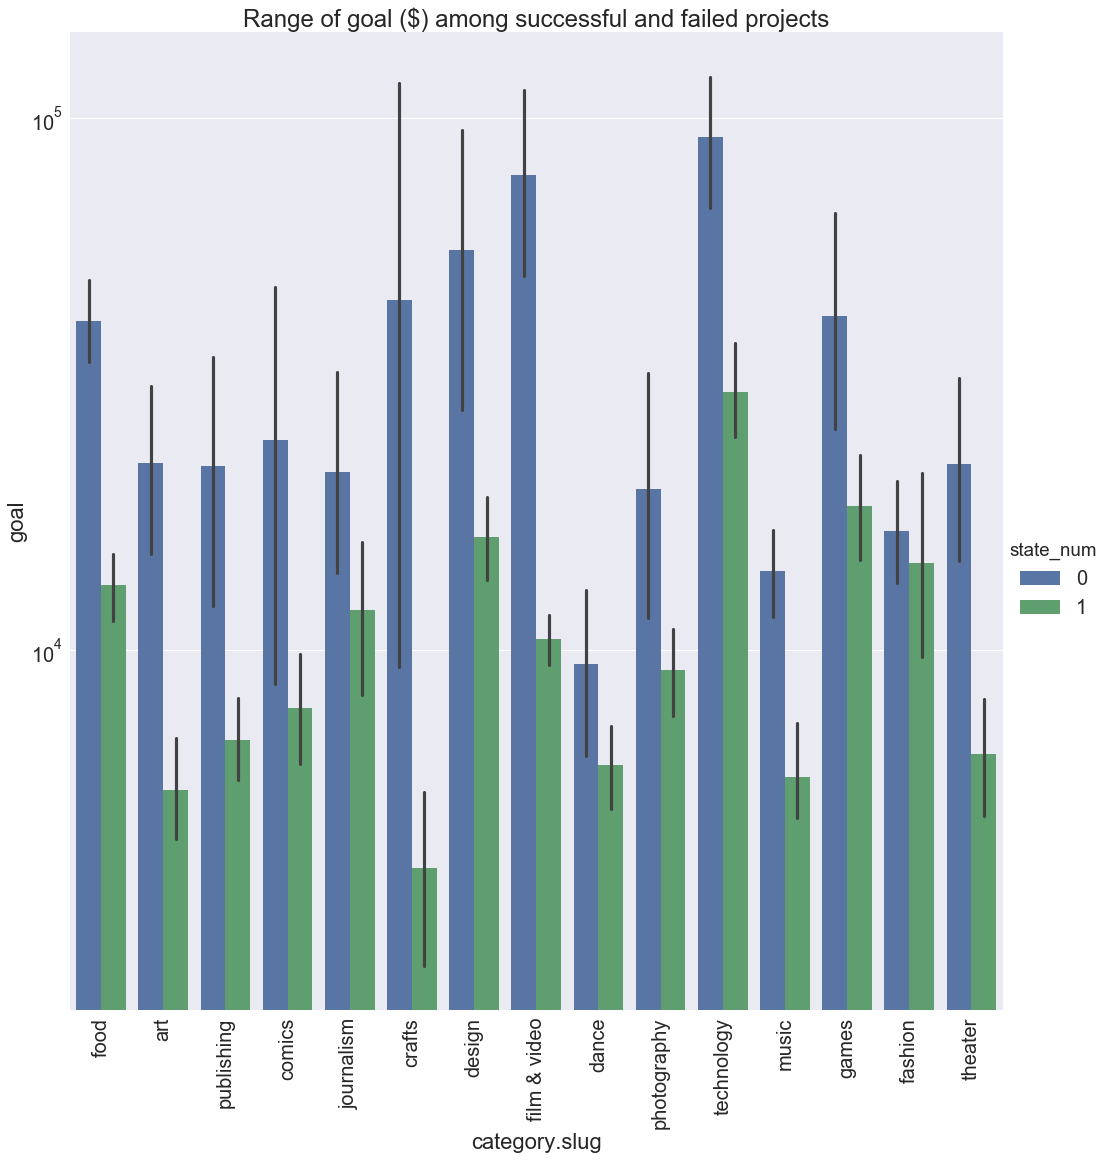

In [36]:
sns.factorplot(x='category.slug', y='goal', hue='state_num', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Range of goal ($) among successful and failed projects')
plt.gca().set_yscale("log", nonposy='clip');
#מראה את הצלחת הפרויקטים לפי סכום היעד לגיוס- רואים שבגדול פרויקטים שנכשלו ביקשו יותר מדי. מצד שני רואים (טבלה הבאה) שפרויקטים שהצליחו לרב יגייסו 150%

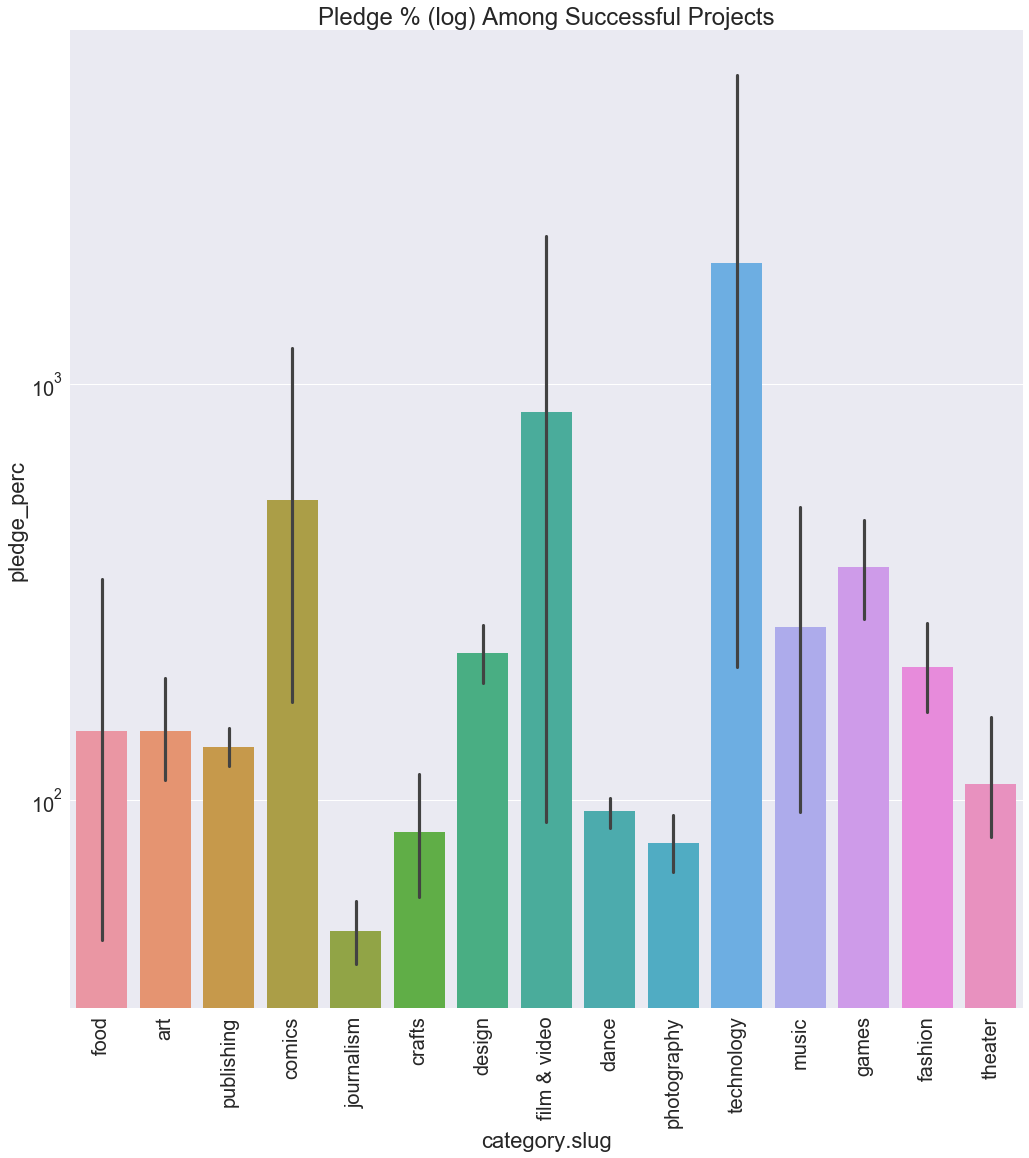

In [37]:
df_suc=data.loc[data['success']==True]
ax=sns.factorplot(x='category.slug', y='pledge_perc', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Pledge % (log) Among Successful Projects')
plt.gca().set_yscale("log", nonposy='clip');
#מה אחוז הגיוס מתוך פריקטים שהצליחו. רואים שניתן לגייס ''פחות'' אבל בפועל יצא יותר

In [38]:
print('Average pledge % per category')
df_suc.groupby('category.slug', as_index=False, sort=False)['pledge_perc'].mean()

Average pledge % per category


,category.slug,pledge_perc
0,art,246.177393
1,food,512.525496
2,publishing,183.133184
3,comics,697.460481
4,journalism,136.455552
5,design,329.647398
6,film & video,1389.244526
7,dance,120.897716
8,photography,185.243332
9,technology,5079.197053


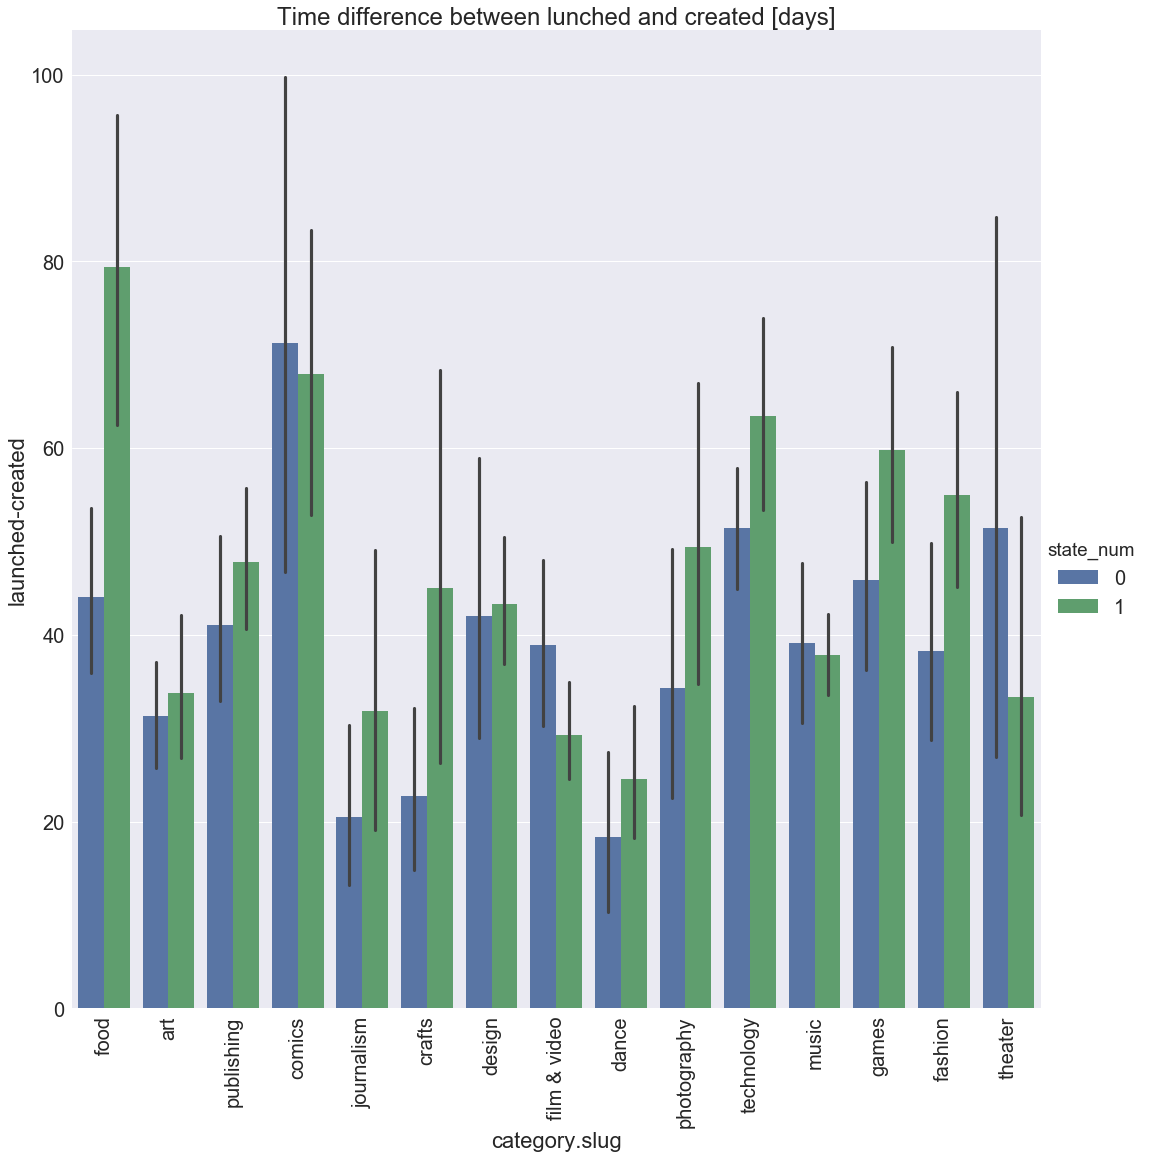

In [39]:
sns.factorplot(x='category.slug', y='launched-created', hue='state_num', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Time difference between lunched and created [days]')
plt.gca().set_yscale("linear", nonposy='clip');
#כמעט תמיד עדיף להשיק אחרי שהקמפייין ''מתבשל'' קצת. חריגים הם הקולנוע והתיאטרון

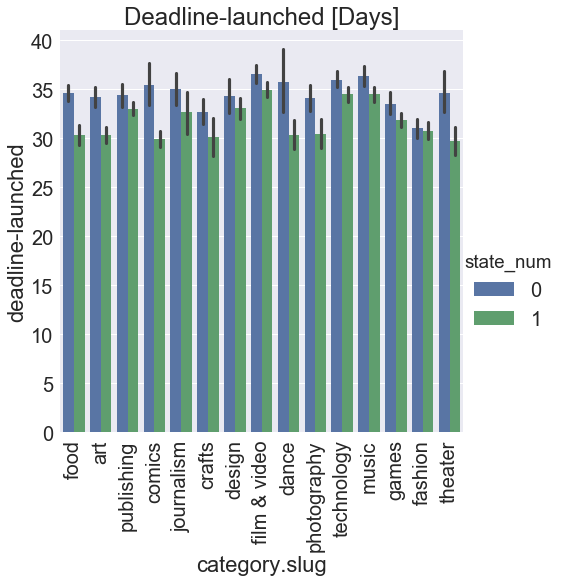

In [40]:
sns.factorplot(x='category.slug', y='deadline-launched', hue='state_num', kind='bar', data=data, size=7)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Deadline-launched [Days]')
plt.gca().set_yscale("linear", nonposy='clip');
#נתון כנראה לא רלוונטי